In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=DOGE&tsym=USD&limit=700')
df = pd.DataFrame(json.loads(res.content)['Data'])
df = df.set_index('time')
df.index = pd.to_datetime(df.index, unit='s')
target_col='close'

In [3]:
df

,high,low,open,volumefrom,volumeto,close,conversionType,conversionSymbol
time,,,,,,,,
2020-12-18,0.004081,0.003638,0.003710,1.192873e+08,456625.06,0.003863,direct,
2020-12-19,0.004317,0.003830,0.003863,1.560903e+08,618294.53,0.003930,direct,
2020-12-20,0.004749,0.003844,0.003930,7.421927e+08,3296192.96,0.004613,direct,
2020-12-21,0.005437,0.004322,0.004613,1.042593e+09,5150418.48,0.004790,direct,
2020-12-22,0.004894,0.004340,0.004790,1.755763e+08,805782.60,0.004511,direct,
...,...,...,...,...,...,...,...,...
2022-11-14,0.091170,0.079110,0.084880,8.673591e+08,73614428.65,0.085800,direct,
2022-11-15,0.089480,0.084750,0.085800,5.717435e+08,49699027.21,0.086940,direct,
2022-11-16,0.091020,0.083300,0.086940,4.397570e+08,38115216.42,0.085440,direct,


In [4]:
df = df.drop(['conversionType','conversionSymbol'], axis=1)
df

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-12-18,0.004081,0.003638,0.003710,1.192873e+08,456625.06,0.003863
2020-12-19,0.004317,0.003830,0.003863,1.560903e+08,618294.53,0.003930
2020-12-20,0.004749,0.003844,0.003930,7.421927e+08,3296192.96,0.004613
2020-12-21,0.005437,0.004322,0.004613,1.042593e+09,5150418.48,0.004790
2020-12-22,0.004894,0.004340,0.004790,1.755763e+08,805782.60,0.004511
...,...,...,...,...,...,...
2022-11-14,0.091170,0.079110,0.084880,8.673591e+08,73614428.65,0.085800
2022-11-15,0.089480,0.084750,0.085800,5.717435e+08,49699027.21,0.086940
2022-11-16,0.091020,0.083300,0.086940,4.397570e+08,38115216.42,0.085440


In [5]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

In [6]:
def train_test_split(df, test_size=0.4):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [7]:
train, test = train_test_split(df,test_size=0.4)

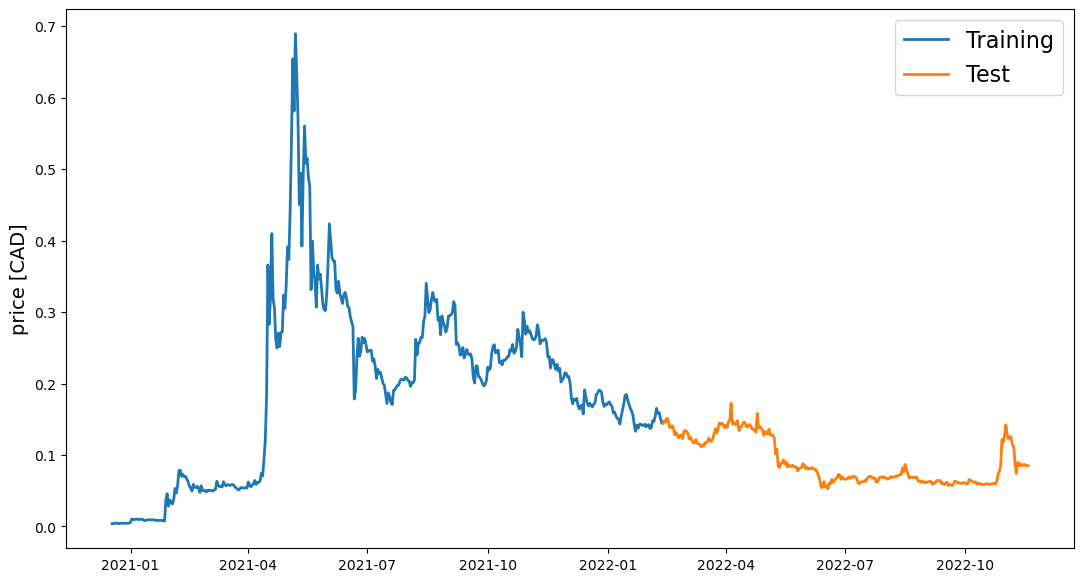

In [8]:
line_plot(train[target_col], test[target_col], 'Training', 'Test', title='')

In [9]:
print(train)
print(test)

                high       low      open    volumefrom      volumeto     close
time                                                                          
2020-12-18  0.004081  0.003638  0.003710  1.192873e+08  4.566251e+05  0.003863
2020-12-19  0.004317  0.003830  0.003863  1.560903e+08  6.182945e+05  0.003930
2020-12-20  0.004749  0.003844  0.003930  7.421927e+08  3.296193e+06  0.004613
2020-12-21  0.005437  0.004322  0.004613  1.042593e+09  5.150418e+06  0.004790
2020-12-22  0.004894  0.004340  0.004790  1.755763e+08  8.057826e+05  0.004511
...              ...       ...       ...           ...           ...       ...
2022-02-07  0.173300  0.151500  0.154100  1.149229e+09  1.873643e+08  0.165300
2022-02-08  0.170000  0.153100  0.165300  5.934907e+08  9.533399e+07  0.158300
2022-02-09  0.162400  0.154400  0.158300  4.981336e+08  7.908832e+07  0.159500
2022-02-10  0.160900  0.150200  0.159500  4.757670e+08  7.428555e+07  0.151600
2022-02-11  0.154400  0.142400  0.151600  3.950202e+

In [10]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [11]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [12]:
def prepare_data(df, target_col, window_len=5, zero_base=True, test_size=0.4):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [13]:
def build_lstm_model(input_data, output_size, neurons=120, activ_func='linear',
                     dropout=0.3, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [14]:
np.random.seed(42)
window_len = 5
test_size = 0.4
zero_base = True
lstm_neurons = 120
epochs = 40
batch_size = 32
loss = 'mse'
dropout = 0.3
optimizer = 'adam'

In [15]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [16]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(mode='min',verbose=1,patience=5)

In [17]:
model = build_lstm_model( X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit( X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.3, validation_data=(X_test,y_test), verbose=1, shuffle=True, callbacks = [es])

Epoch 1/40
13/13 [==============================] - 3s 56ms/step - loss: 0.1702 - val_loss: 0.0105
Epoch 2/40
13/13 [==============================] - 0s 7ms/step - loss: 0.1309 - val_loss: 0.0085
Epoch 3/40
13/13 [==============================] - 0s 7ms/step - loss: 0.1360 - val_loss: 0.0092
Epoch 4/40
13/13 [==============================] - 0s 7ms/step - loss: 0.1063 - val_loss: 0.0078
Epoch 5/40
13/13 [==============================] - 0s 7ms/step - loss: 0.0922 - val_loss: 0.0081
Epoch 6/40
13/13 [==============================] - 0s 8ms/step - loss: 0.0811 - val_loss: 0.0081
Epoch 7/40
13/13 [==============================] - 0s 7ms/step - loss: 0.0835 - val_loss: 0.0087
Epoch 8/40
13/13 [==============================] - 0s 7ms/step - loss: 0.0875 - val_loss: 0.0075
Epoch 9/40
13/13 [==============================] - 0s 7ms/step - loss: 0.0816 - val_loss: 0.0105
Epoch 10/40
13/13 [==============================] - 0s 7ms/step - loss: 0.0775 - val_loss: 0.0070
Epoch 11/40
13/13 

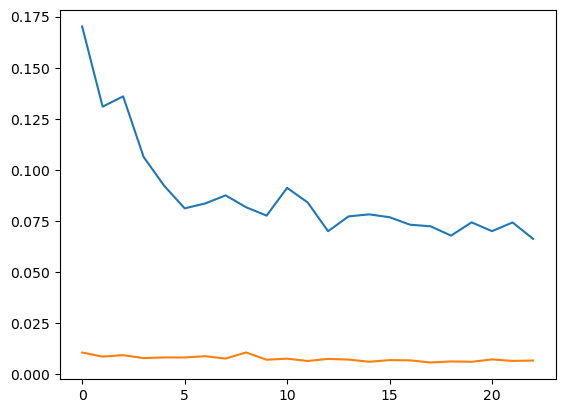

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

In [19]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

9/9 [==============================] - 1s 2ms/step


0.056125411785394264

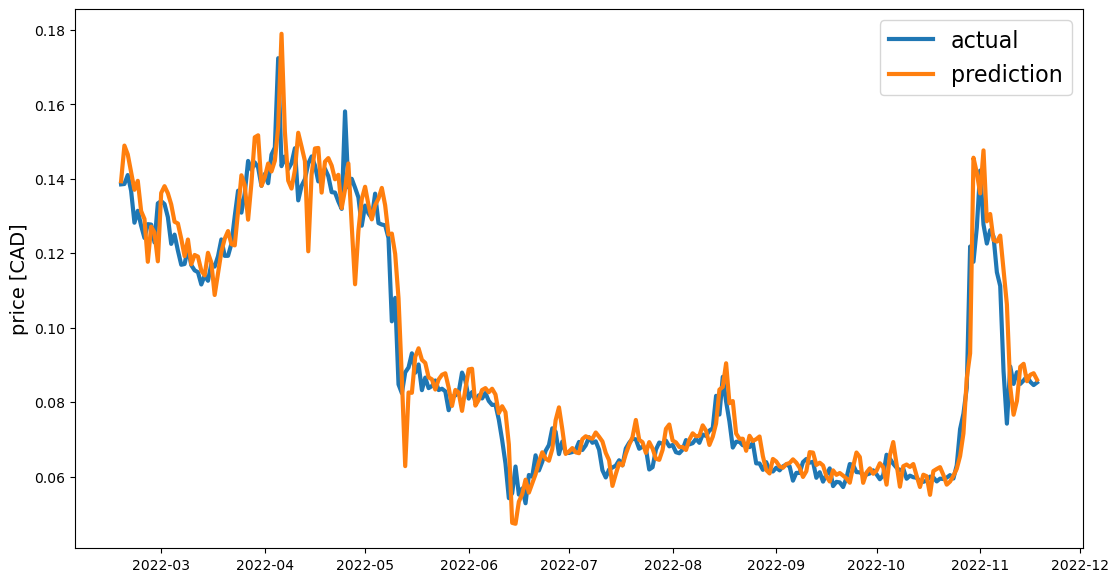

In [20]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [21]:
model.save('DOGEmodel.hdf5')